# Finetuning hyperparmeters for the neural nets  

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle

print(tf.__version__)
print(keras.__version__)

#Is GPU available
print("GPU available: ", tf.test.is_gpu_available())


W0301 22:09:10.763536  1936 deprecation.py:323] From <ipython-input-1-07cd62b9a160>:12: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2.1.0
2.2.4-tf
GPU available:  True


In [2]:
#Load data
fashion_mnist =keras.datasets.fashion_mnist

(X_train_full,y_train_full),(X_test,y_test)= fashion_mnist.load_data()

print(X_train_full.shape)
print(X_test.shape)



(60000, 28, 28)
(10000, 28, 28)


In [3]:
# Create the validation dataset
percent_samples = 20
total_samples = X_train_full.shape[0]

num_validation_samples =int(total_samples * percent_samples / 100)

print("Num validation samples: {}".format(num_validation_samples))
print("Total training samples: {}".format(total_samples))

#Get shuffled indices
a = np.arange(total_samples)
shuffled_idx =shuffle(a)

#Create validation indices
idx_val =shuffled_idx[:num_validation_samples]

#Create trainng indices
idx_training =shuffled_idx[num_validation_samples:]

#Slice the dataset and normalize it to 0 - 1
X_train, X_valid = X_train_full[idx_training] / 255.0, X_train_full[idx_val] / 255.0
y_train, y_valid = y_train_full[idx_training], y_train_full[idx_val]


#Specify the class names
class_names = ["tshirt", "trouser", "Pullover","Dress","Coat","Sandat","Shirt","Sneaker","Bag","Ankle boot"]


# Create size variables
num_training_samples = X_train.shape[0]
num_validation_samples = X_valid.shape[0]
num_test_samples = X_test.shape[0]
num_classes = np.unique(y_train).shape[0]

#Display info
print("num_training_samples: {}".format(num_training_samples))
print("num_validation_samples: {}".format(num_validation_samples))
print("num_test_samples: {}".format(num_test_samples))
print("num_classes: {}".format(num_classes))


Num validation samples: 12000
Total training samples: 60000
num_training_samples: 48000
num_validation_samples: 12000
num_test_samples: 10000
num_classes: 10


Showing training data on grid of rows=4, cols=3


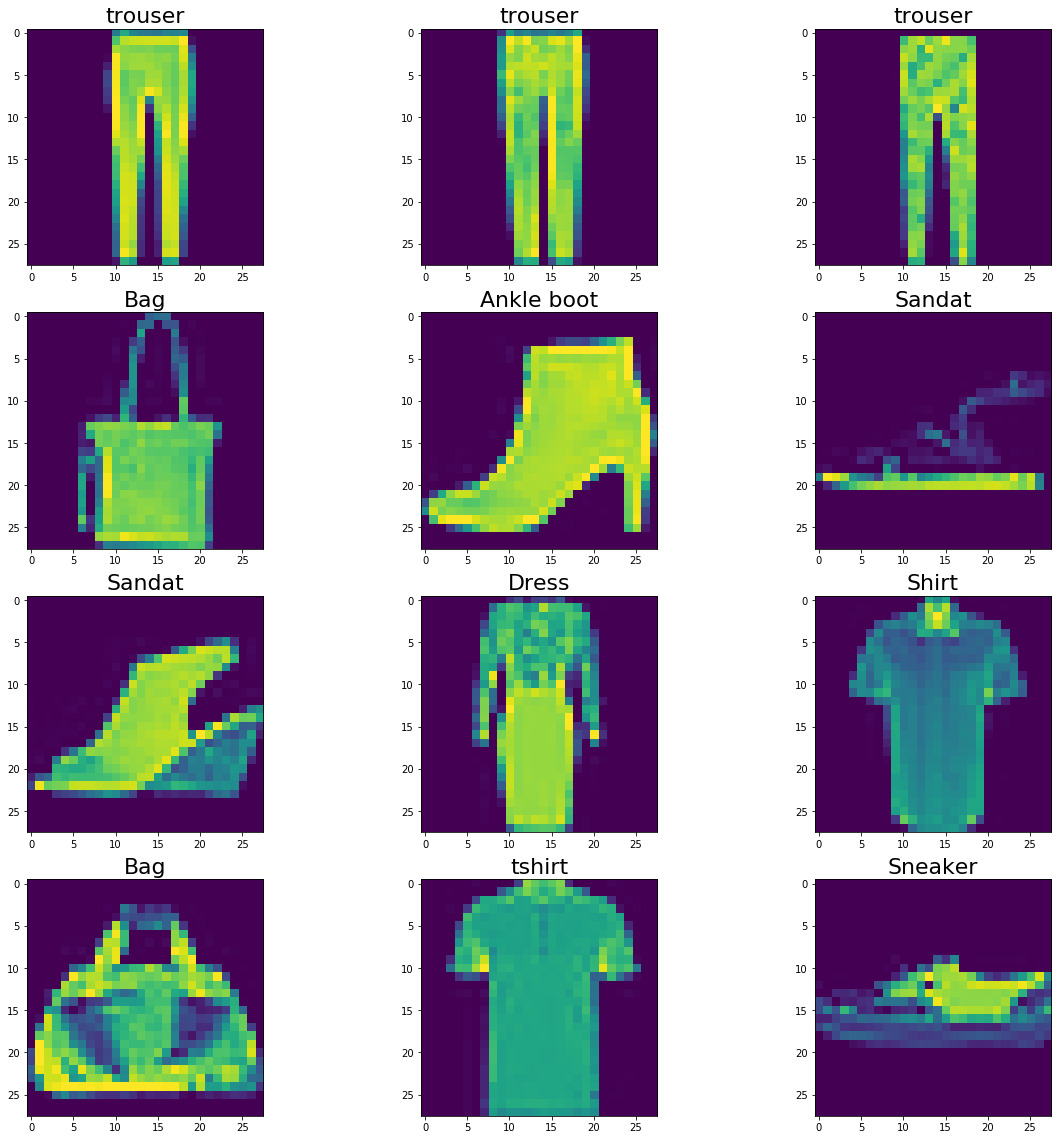

In [4]:
## Data exploration
num_show_samples=12
idx_show = random.sample(range(num_training_samples),num_show_samples)

rows = 4
cols = int(np.ceil(num_show_samples/rows))
print("Showing training data on grid of rows={}, cols={}".format(rows,cols))

plt.figure(figsize=(20,20))
for i in range(num_show_samples):
    ax = plt.subplot(rows,cols,i+1)
    plt.imshow(X_train[idx_show[i]])
    plt.title("{}".format(class_names[y_train[idx_show[i]]]), fontsize=22)


## Are the classes well represented?

In this case, seems like the classes are well represented. If that wasn't the case, you could augment the data, and/or, use class_weights in the Sequential API for assigning more/less weight to certain classes based on their frequency

['tshirt', 'trouser', 'Pullover', 'Dress', 'Coat', 'Sandat', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


[Text(0, 0, 'tshirt'),
 Text(0, 0, 'trouser'),
 Text(0, 0, 'Pullover'),
 Text(0, 0, 'Dress'),
 Text(0, 0, 'Coat'),
 Text(0, 0, 'Sandat'),
 Text(0, 0, 'Shirt'),
 Text(0, 0, 'Sneaker'),
 Text(0, 0, 'Bag'),
 Text(0, 0, 'Ankle boot')]

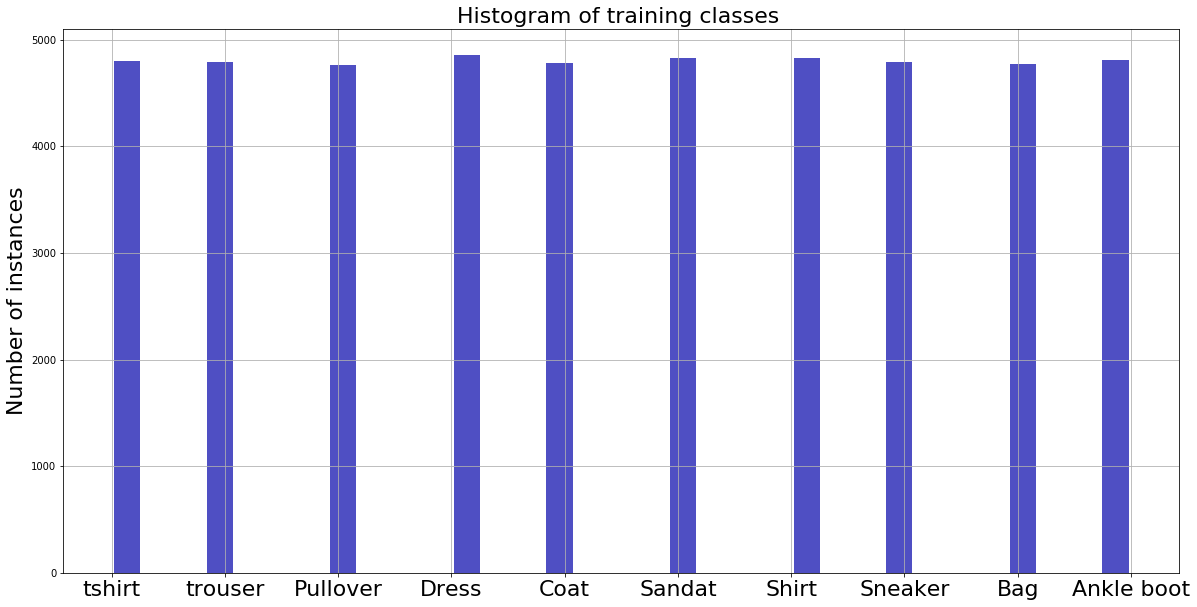

In [5]:
# Are the classes well represented?
plt.figure(figsize=(20,10))

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(y_train, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.title("Histogram of training classes ", fontsize=22)
plt.grid('on')
plt.ylabel("Number of instances", fontsize=22)

xtick_labels = class_names
print(xtick_labels)

# # now, define the ticks (i.e. locations where the labels will be plotted)
xticks = [i for i in range(num_classes)]

# # also define the labels we'll use (note this MUST have the same size as `xticks`!)
# xtick_labels = ['Family-%d' % (f+1) for f in range(NUM_FAMILIES)]

ax = plt.gca()
# add the ticks and labels to the plot
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels,fontsize=22)


## Callbacks for the model 
### Note: Unable to get launch tensorboard with right directory from the notebook on Windows. Instead, just start tensorboard from the command line externally


In [6]:
# Use save Modelcheckpoint callback so that I have intermediate versions of the trained model before the training has completed.
    #Byt default, this saves model at end of each epoch, but callbacks can be called at 
    # start/end of epoch, start/end of each batch, start/end of training 

#Use EarlyStopping to reduce resource usage.

import os

model_folder_name = "mlp_hyperparam_tuning"
model_name = model_folder_name + ".h5"


#ModelCheckpoint - Save only the best model
save_model_filepath = os.path.join(os.pardir,"models",model_folder_name,model_name)

print("ModelCheckpoint Callback saves the model in: {}".format(save_model_filepath))

checkpoint_cb = keras.callbacks.ModelCheckpoint(save_model_filepath,
                                               save_best_only=True)

# Early stopping.
# ModelCheckpoint will save best, but wont stop training, which might go on for a long time and consume resources.
# Early stoppoing callback helps with this
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                      patience=10,
#                                                      restore_best_weights=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

#Create a custom callback if needed. For example, display the ratio of validation loss / training_loss to detect overfitting
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        print("\n Custom Callback - Epoch: {}, val/train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))

#Instance of the custom callback
print_ratio_cb = PrintValTrainRatioCallback()


#Tensorboard callback

#Note:
#For windows, forward and back slahses are painful to get right for the tensorboard usage.
# What works is that create a windows path, and replace the \ with \\

#Save data in models folder.
root_logdir = os.path.join(os.pardir, "models", model_folder_name, "tensorboard", "my_logs")
print("Tensorboard parent logs folder: {}".format(root_logdir))

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)

run_logdir = get_run_logdir()
print("Current logdir: {}".format(run_logdir))

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
# tensorboard_cb = keras.callbacks.TensorBoard("C:/Users/abhat/research/Tensorflow_2.0_tutorials/models/mlp_basic/tensorboard/my_logs")

# print("Note: Unable to get launch tensorboard with right directory from the notebook on Windows." 
#       "Instead, just start tensorboard from the command line externally")

#Note: Unable to get launch tensorboard with right directory from the notebook on Windows. 
#Instead, just start tensorboard from the command line externally

# print("Launching Tensorboard for visualization...")
# %load_ext tensorboard
# %tensorboard --logdir=run_logdir --port=6006
# %tensorboard --logdir="C:\Users\abhat\research\Tensorflow_2.0_tutorials\models\mlp_basic\tensorboard\my_logs" --port=6006


ModelCheckpoint Callback saves the model in: ..\models\mlp_hyperparam_tuning\mlp_hyperparam_tuning.h5
Tensorboard parent logs folder: ..\models\mlp_hyperparam_tuning\tensorboard\my_logs
Current logdir: ..\models\mlp_hyperparam_tuning\tensorboard\my_logs\run_2020_03_01_22_09_15


In [7]:
# Create a function that will return a Sequential model
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[28,28]):

    model = keras.models.Sequential(name="hyp_tuning_mlp")
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    model.add(keras.layers.Flatten())
    #Add the hidden layers
    for i in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation='relu'))
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                 metrics=["accuracy"])
        
    return model


model = build_model()
model.summary()



Model: "hyp_tuning_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 30)                23550     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________


## Create a Keras regressor and use randomized search for testing various hyperparameters


In [8]:

#Create a KerasRegressor based on the build_model()
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# keras_reg.fit(X_train,y_train,epochs=10,
#                   validation_data=(X_valid,y_valid))

# Create the RandomizedSearchCV 
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs ={
    "n_hidden"  : [0, 1 , 2, 3],
    "n_neurons" : [10, 30, 50],
    "learning_rate" : reciprocal(3e-4, 3e-2),    
}


rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs,n_iter=10,cv=3)
rnd_search_cv.fit(X_train,y_train,epochs=100,
                  validation_data=(X_valid,y_valid),
                 callbacks=[checkpoint_cb, early_stopping_cb, print_ratio_cb, tensorboard_cb])


Train on 32000 samples, validate on 12000 samples
Epoch 1/100
31456/32000 [============================>.] - ETA: 0s - loss: 1.9239 - accuracy: 0.3279
 Custom Callback - Epoch: 0, val/train loss ratio: 0.84
32000/32000 [==============================] - 5s 159us/sample - loss: 1.9186 - accuracy: 0.3299 - val_loss: 1.6067 - val_accuracy: 0.4436
Epoch 2/100
31936/32000 [============================>.] - ETA: 0s - loss: 1.3543 - accuracy: 0.5124
 Custom Callback - Epoch: 1, val/train loss ratio: 0.84
32000/32000 [==============================] - 4s 137us/sample - loss: 1.3539 - accuracy: 0.5126 - val_loss: 1.1420 - val_accuracy: 0.5851
Epoch 3/100
31552/32000 [============================>.] - ETA: 0s - loss: 1.0517 - accuracy: 0.6126
 Custom Callback - Epoch: 2, val/train loss ratio: 0.92
32000/32000 [==============================] - 4s 137us/sample - loss: 1.0506 - accuracy: 0.6134 - val_loss: 0.9637 - val_accuracy: 0.6296
Epoch 4/100
31936/32000 [============================>.] - ETA

Epoch 29/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.5007 - accuracy: 0.8319
 Custom Callback - Epoch: 28, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 139us/sample - loss: 0.5006 - accuracy: 0.8316 - val_loss: 0.5000 - val_accuracy: 0.8270
Epoch 30/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4969 - accuracy: 0.8331
 Custom Callback - Epoch: 29, val/train loss ratio: 1.01
32000/32000 [==============================] - 5s 143us/sample - loss: 0.4965 - accuracy: 0.8330 - val_loss: 0.5023 - val_accuracy: 0.8272
Epoch 31/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4937 - accuracy: 0.8339
 Custom Callback - Epoch: 30, val/train loss ratio: 1.00
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4927 - accuracy: 0.8341 - val_loss: 0.4930 - val_accuracy: 0.8300
Epoch 32/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4892 - accuracy: 0.8346
 Cus

Epoch 57/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4364 - accuracy: 0.8498
 Custom Callback - Epoch: 56, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 138us/sample - loss: 0.4377 - accuracy: 0.8495 - val_loss: 0.4534 - val_accuracy: 0.8427
Epoch 58/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.4365 - accuracy: 0.8496
 Custom Callback - Epoch: 57, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 138us/sample - loss: 0.4362 - accuracy: 0.8498 - val_loss: 0.4490 - val_accuracy: 0.8428
Epoch 59/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4353 - accuracy: 0.8497
 Custom Callback - Epoch: 58, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 139us/sample - loss: 0.4350 - accuracy: 0.8499 - val_loss: 0.4473 - val_accuracy: 0.8447
Epoch 60/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8509
 Cus

Epoch 2/100
31968/32000 [============================>.] - ETA: 0s - loss: 2.0502 - accuracy: 0.2025
 Custom Callback - Epoch: 1, val/train loss ratio: 0.93
32000/32000 [==============================] - 4s 140us/sample - loss: 2.0501 - accuracy: 0.2025 - val_loss: 1.9142 - val_accuracy: 0.3036
Epoch 3/100
31648/32000 [============================>.] - ETA: 0s - loss: 1.6991 - accuracy: 0.4525
 Custom Callback - Epoch: 2, val/train loss ratio: 0.84
32000/32000 [==============================] - 4s 138us/sample - loss: 1.6961 - accuracy: 0.4540 - val_loss: 1.4288 - val_accuracy: 0.5705
Epoch 4/100
31840/32000 [============================>.] - ETA: 0s - loss: 1.2448 - accuracy: 0.6003
 Custom Callback - Epoch: 3, val/train loss ratio: 0.88
32000/32000 [==============================] - 4s 138us/sample - loss: 1.2439 - accuracy: 0.6006 - val_loss: 1.0942 - val_accuracy: 0.6373
Epoch 5/100
31968/32000 [============================>.] - ETA: 0s - loss: 1.0220 - accuracy: 0.6509
 Custom Cal

Epoch 30/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.5163 - accuracy: 0.8217
 Custom Callback - Epoch: 29, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 137us/sample - loss: 0.5160 - accuracy: 0.8218 - val_loss: 0.5160 - val_accuracy: 0.8202
Epoch 31/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.5111 - accuracy: 0.8217
 Custom Callback - Epoch: 30, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 138us/sample - loss: 0.5116 - accuracy: 0.8217 - val_loss: 0.5149 - val_accuracy: 0.8176
Epoch 32/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.5085 - accuracy: 0.8221
 Custom Callback - Epoch: 31, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 137us/sample - loss: 0.5086 - accuracy: 0.8221 - val_loss: 0.5122 - val_accuracy: 0.8234
Epoch 33/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.5049 - accuracy: 0.8242
 Cus

Epoch 58/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4517 - accuracy: 0.8423
 Custom Callback - Epoch: 57, val/train loss ratio: 1.04
32000/32000 [==============================] - 5s 145us/sample - loss: 0.4520 - accuracy: 0.8422 - val_loss: 0.4689 - val_accuracy: 0.8357
Epoch 59/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.8435
 Custom Callback - Epoch: 58, val/train loss ratio: 1.04
32000/32000 [==============================] - 5s 144us/sample - loss: 0.4506 - accuracy: 0.8437 - val_loss: 0.4689 - val_accuracy: 0.8386
Epoch 60/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4505 - accuracy: 0.8438
 Custom Callback - Epoch: 59, val/train loss ratio: 1.03
32000/32000 [==============================] - 5s 143us/sample - loss: 0.4502 - accuracy: 0.8439 - val_loss: 0.4644 - val_accuracy: 0.8393
Epoch 61/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.4485 - accuracy: 0.8434
 Cus

Epoch 86/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4241 - accuracy: 0.8519
 Custom Callback - Epoch: 85, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4237 - accuracy: 0.8520 - val_loss: 0.4471 - val_accuracy: 0.8441
Epoch 87/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4226 - accuracy: 0.8526
 Custom Callback - Epoch: 86, val/train loss ratio: 1.05
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4226 - accuracy: 0.8525 - val_loss: 0.4456 - val_accuracy: 0.8449
Epoch 88/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.4222 - accuracy: 0.8513
 Custom Callback - Epoch: 87, val/train loss ratio: 1.06
32000/32000 [==============================] - 5s 144us/sample - loss: 0.4222 - accuracy: 0.8513 - val_loss: 0.4492 - val_accuracy: 0.8448
Epoch 89/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.4215 - accuracy: 0.8524
 Cus

31488/32000 [============================>.] - ETA: 0s - loss: 0.7051 - accuracy: 0.7476
 Custom Callback - Epoch: 12, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 137us/sample - loss: 0.7042 - accuracy: 0.7481 - val_loss: 0.6975 - val_accuracy: 0.7476
Epoch 14/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.7524
 Custom Callback - Epoch: 13, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 137us/sample - loss: 0.6893 - accuracy: 0.7523 - val_loss: 0.6855 - val_accuracy: 0.7553
Epoch 15/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.7587
 Custom Callback - Epoch: 14, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 137us/sample - loss: 0.6769 - accuracy: 0.7585 - val_loss: 0.6676 - val_accuracy: 0.7637
Epoch 16/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.6647 - accuracy: 0.7626
 Custom Callback 

31808/32000 [============================>.] - ETA: 0s - loss: 0.4955 - accuracy: 0.8272
 Custom Callback - Epoch: 39, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4953 - accuracy: 0.8275 - val_loss: 0.5008 - val_accuracy: 0.8263
Epoch 41/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4910 - accuracy: 0.8295 ETA: 0s - loss: 0.4920 - 
 Custom Callback - Epoch: 40, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4918 - accuracy: 0.8291 - val_loss: 0.5002 - val_accuracy: 0.8268
Epoch 42/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4882 - accuracy: 0.8296
 Custom Callback - Epoch: 41, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4881 - accuracy: 0.8296 - val_loss: 0.4985 - val_accuracy: 0.8295
Epoch 43/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4854 - accuracy

Epoch 3/100
31424/32000 [============================>.] - ETA: 0s - loss: 1.2317 - accuracy: 0.6665
 Custom Callback - Epoch: 2, val/train loss ratio: 0.93
32000/32000 [==============================] - 4s 127us/sample - loss: 1.2309 - accuracy: 0.6662 - val_loss: 1.1484 - val_accuracy: 0.6775
Epoch 4/100
31872/32000 [============================>.] - ETA: 0s - loss: 1.1074 - accuracy: 0.6832
 Custom Callback - Epoch: 3, val/train loss ratio: 0.95
32000/32000 [==============================] - 4s 127us/sample - loss: 1.1074 - accuracy: 0.6832 - val_loss: 1.0517 - val_accuracy: 0.6931
Epoch 5/100
31456/32000 [============================>.] - ETA: 0s - loss: 1.0284 - accuracy: 0.6947
 Custom Callback - Epoch: 4, val/train loss ratio: 0.96
32000/32000 [==============================] - 4s 126us/sample - loss: 1.0276 - accuracy: 0.6949 - val_loss: 0.9856 - val_accuracy: 0.7046
Epoch 6/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.9710 - accuracy: 0.7049
 Custom Cal

Epoch 31/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.7919
 Custom Callback - Epoch: 30, val/train loss ratio: 0.98
32000/32000 [==============================] - 4s 126us/sample - loss: 0.6533 - accuracy: 0.7919 - val_loss: 0.6420 - val_accuracy: 0.7939
Epoch 32/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.6487 - accuracy: 0.7939
 Custom Callback - Epoch: 31, val/train loss ratio: 0.98
32000/32000 [==============================] - 4s 126us/sample - loss: 0.6490 - accuracy: 0.7938 - val_loss: 0.6380 - val_accuracy: 0.7950
Epoch 33/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.7942
 Custom Callback - Epoch: 32, val/train loss ratio: 0.98
32000/32000 [==============================] - 4s 126us/sample - loss: 0.6451 - accuracy: 0.7943 - val_loss: 0.6342 - val_accuracy: 0.7964
Epoch 34/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.6409 - accuracy: 0.7960
 Cus

Epoch 59/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.5779 - accuracy: 0.8139
 Custom Callback - Epoch: 58, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5783 - accuracy: 0.8137 - val_loss: 0.5716 - val_accuracy: 0.8138
Epoch 60/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.5771 - accuracy: 0.8149
 Custom Callback - Epoch: 59, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5767 - accuracy: 0.8150 - val_loss: 0.5699 - val_accuracy: 0.8140
Epoch 61/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.5751 - accuracy: 0.8150
 Custom Callback - Epoch: 60, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5749 - accuracy: 0.8151 - val_loss: 0.5685 - val_accuracy: 0.8152
Epoch 62/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.5730 - accuracy: 0.8158
 Cus

Epoch 87/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.5417 - accuracy: 0.8251
 Custom Callback - Epoch: 86, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5418 - accuracy: 0.8250 - val_loss: 0.5381 - val_accuracy: 0.8242
Epoch 88/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.5411 - accuracy: 0.8255 ETA: 0s - loss:
 Custom Callback - Epoch: 87, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5409 - accuracy: 0.8256 - val_loss: 0.5371 - val_accuracy: 0.8244
Epoch 89/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.5396 - accuracy: 0.8260
 Custom Callback - Epoch: 88, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5397 - accuracy: 0.8257 - val_loss: 0.5364 - val_accuracy: 0.8246
Epoch 90/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.5394 - accur

Epoch 14/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.7775 - accuracy: 0.7510
 Custom Callback - Epoch: 13, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 127us/sample - loss: 0.7768 - accuracy: 0.7516 - val_loss: 0.7672 - val_accuracy: 0.7575
Epoch 15/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.7649 - accuracy: 0.7558
 Custom Callback - Epoch: 14, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 133us/sample - loss: 0.7644 - accuracy: 0.7558 - val_loss: 0.7553 - val_accuracy: 0.7608
Epoch 16/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.7527 - accuracy: 0.7583 ETA: 1s - loss: 0.7523 - accu - ETA: 0s - los
 Custom Callback - Epoch: 15, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 128us/sample - loss: 0.7529 - accuracy: 0.7584 - val_loss: 0.7451 - val_accuracy: 0.7663
Epoch 17/100
31456/32000 [============================>.] - 

31904/32000 [============================>.] - ETA: 0s - loss: 0.6189 - accuracy: 0.7995
 Custom Callback - Epoch: 40, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 127us/sample - loss: 0.6185 - accuracy: 0.7996 - val_loss: 0.6154 - val_accuracy: 0.8025
Epoch 42/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.6159 - accuracy: 0.8002
 Custom Callback - Epoch: 41, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 127us/sample - loss: 0.6157 - accuracy: 0.8003 - val_loss: 0.6125 - val_accuracy: 0.8034
Epoch 43/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.6125 - accuracy: 0.8012
 Custom Callback - Epoch: 42, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 127us/sample - loss: 0.6130 - accuracy: 0.8012 - val_loss: 0.6100 - val_accuracy: 0.8049
Epoch 44/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.6102 - accuracy: 0.8023
 Custom Callback 

Epoch 69/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.5636 - accuracy: 0.8147 ETA: 0s - loss: 0.5667 - accura
 Custom Callback - Epoch: 68, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5632 - accuracy: 0.8150 - val_loss: 0.5625 - val_accuracy: 0.8170
Epoch 70/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.5617 - accuracy: 0.8157
 Custom Callback - Epoch: 69, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5618 - accuracy: 0.8155 - val_loss: 0.5612 - val_accuracy: 0.8181
Epoch 71/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.5605 - accuracy: 0.8158
 Custom Callback - Epoch: 70, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5604 - accuracy: 0.8159 - val_loss: 0.5599 - val_accuracy: 0.8180
Epoch 72/100
31520/32000 [============================>.] - ETA: 0s - loss

31968/32000 [============================>.] - ETA: 0s - loss: 0.5335 - accuracy: 0.8241
 Custom Callback - Epoch: 95, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5335 - accuracy: 0.8242 - val_loss: 0.5346 - val_accuracy: 0.8243
Epoch 97/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.5326 - accuracy: 0.8236
 Custom Callback - Epoch: 96, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5326 - accuracy: 0.8237 - val_loss: 0.5341 - val_accuracy: 0.8251
Epoch 98/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.5314 - accuracy: 0.8241
 Custom Callback - Epoch: 97, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 128us/sample - loss: 0.5318 - accuracy: 0.8240 - val_loss: 0.5331 - val_accuracy: 0.8251
Epoch 99/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.5309 - accuracy: 0.8246
 Custom Callback 

Epoch 23/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.7792
 Custom Callback - Epoch: 22, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 126us/sample - loss: 0.6943 - accuracy: 0.7793 - val_loss: 0.6859 - val_accuracy: 0.7822
Epoch 24/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.7810
 Custom Callback - Epoch: 23, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 126us/sample - loss: 0.6879 - accuracy: 0.7810 - val_loss: 0.6799 - val_accuracy: 0.7834
Epoch 25/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.7837
 Custom Callback - Epoch: 24, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 126us/sample - loss: 0.6820 - accuracy: 0.7837 - val_loss: 0.6742 - val_accuracy: 0.7858
Epoch 26/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.7856
 Cus

31392/32000 [============================>.] - ETA: 0s - loss: 0.5935 - accuracy: 0.8098
 Custom Callback - Epoch: 49, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5934 - accuracy: 0.8095 - val_loss: 0.5905 - val_accuracy: 0.8083
Epoch 51/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.5917 - accuracy: 0.8103
 Custom Callback - Epoch: 50, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5913 - accuracy: 0.8102 - val_loss: 0.5885 - val_accuracy: 0.8098
Epoch 52/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.5892 - accuracy: 0.8110
 Custom Callback - Epoch: 51, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5892 - accuracy: 0.8110 - val_loss: 0.5864 - val_accuracy: 0.8103
Epoch 53/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.5874 - accuracy: 0.8112
 Custom Callback 

31520/32000 [============================>.] - ETA: 0s - loss: 0.5504 - accuracy: 0.8209
 Custom Callback - Epoch: 76, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5497 - accuracy: 0.8210 - val_loss: 0.5499 - val_accuracy: 0.8222
Epoch 78/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.5485 - accuracy: 0.8215
 Custom Callback - Epoch: 77, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5485 - accuracy: 0.8216 - val_loss: 0.5489 - val_accuracy: 0.8227
Epoch 79/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.5473 - accuracy: 0.8219
 Custom Callback - Epoch: 78, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5473 - accuracy: 0.8220 - val_loss: 0.5478 - val_accuracy: 0.8228
Epoch 80/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.5460 - accuracy: 0.8218
 Custom Callback 

Epoch 4/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.6489 - accuracy: 0.7927
 Custom Callback - Epoch: 3, val/train loss ratio: 0.96
32000/32000 [==============================] - 4s 127us/sample - loss: 0.6490 - accuracy: 0.7927 - val_loss: 0.6256 - val_accuracy: 0.7960
Epoch 5/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.6179 - accuracy: 0.8016
 Custom Callback - Epoch: 4, val/train loss ratio: 0.97
32000/32000 [==============================] - 4s 127us/sample - loss: 0.6179 - accuracy: 0.8014 - val_loss: 0.5992 - val_accuracy: 0.8051
Epoch 6/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.5958 - accuracy: 0.8096
 Custom Callback - Epoch: 5, val/train loss ratio: 0.98
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5957 - accuracy: 0.8095 - val_loss: 0.5810 - val_accuracy: 0.8096
Epoch 7/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.5791 - accuracy: 0.8148
 Custom Cal

31936/32000 [============================>.] - ETA: 0s - loss: 0.4625 - accuracy: 0.8467 ETA: 2s - l
 Custom Callback - Epoch: 30, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4630 - accuracy: 0.8464 - val_loss: 0.4699 - val_accuracy: 0.8416
Epoch 32/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4623 - accuracy: 0.8463
 Custom Callback - Epoch: 31, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4615 - accuracy: 0.8469 - val_loss: 0.4673 - val_accuracy: 0.8428
Epoch 33/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4596 - accuracy: 0.8477
 Custom Callback - Epoch: 32, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4596 - accuracy: 0.8478 - val_loss: 0.4657 - val_accuracy: 0.8423
Epoch 34/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4586 - accuracy: 0.8473
 Cust

31456/32000 [============================>.] - ETA: 0s - loss: 0.4325 - accuracy: 0.8549
 Custom Callback - Epoch: 57, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4325 - accuracy: 0.8550 - val_loss: 0.4460 - val_accuracy: 0.8477
Epoch 59/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4310 - accuracy: 0.8554
 Custom Callback - Epoch: 58, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4316 - accuracy: 0.8553 - val_loss: 0.4457 - val_accuracy: 0.8478
Epoch 60/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4313 - accuracy: 0.8564
 Custom Callback - Epoch: 59, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4309 - accuracy: 0.8566 - val_loss: 0.4444 - val_accuracy: 0.8500
Epoch 61/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4299 - accuracy: 0.8561
 Custom Callback 

Epoch 86/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.4157 - accuracy: 0.8612
 Custom Callback - Epoch: 85, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4162 - accuracy: 0.8611 - val_loss: 0.4349 - val_accuracy: 0.8512
Epoch 87/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4158 - accuracy: 0.8600
 Custom Callback - Epoch: 86, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4158 - accuracy: 0.8600 - val_loss: 0.4351 - val_accuracy: 0.8516
Epoch 88/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4150 - accuracy: 0.8606
 Custom Callback - Epoch: 87, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4153 - accuracy: 0.8607 - val_loss: 0.4363 - val_accuracy: 0.8532
Epoch 89/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4141 - accuracy: 0.8609
 Cus

Epoch 13/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.5184 - accuracy: 0.8284
 Custom Callback - Epoch: 12, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5188 - accuracy: 0.8283 - val_loss: 0.5160 - val_accuracy: 0.8287
Epoch 14/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.5125 - accuracy: 0.8309
 Custom Callback - Epoch: 13, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5128 - accuracy: 0.8308 - val_loss: 0.5109 - val_accuracy: 0.8324
Epoch 15/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.5082 - accuracy: 0.8308
 Custom Callback - Epoch: 14, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 128us/sample - loss: 0.5076 - accuracy: 0.8310 - val_loss: 0.5074 - val_accuracy: 0.8321
Epoch 16/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.5024 - accuracy: 0.8331
 Cus

31744/32000 [============================>.] - ETA: 0s - loss: 0.4468 - accuracy: 0.8492
 Custom Callback - Epoch: 39, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4473 - accuracy: 0.8488 - val_loss: 0.4553 - val_accuracy: 0.8471
Epoch 41/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.4458 - accuracy: 0.8499
 Custom Callback - Epoch: 40, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4458 - accuracy: 0.8500 - val_loss: 0.4544 - val_accuracy: 0.8469
Epoch 42/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.4447 - accuracy: 0.8501
 Custom Callback - Epoch: 41, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4447 - accuracy: 0.8499 - val_loss: 0.4537 - val_accuracy: 0.8480
Epoch 43/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4430 - accuracy: 0.8518
 Custom Callback 

31584/32000 [============================>.] - ETA: 0s - loss: 0.4232 - accuracy: 0.8573
 Custom Callback - Epoch: 66, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4232 - accuracy: 0.8574 - val_loss: 0.4379 - val_accuracy: 0.8508
Epoch 68/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4223 - accuracy: 0.8580
 Custom Callback - Epoch: 67, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4224 - accuracy: 0.8578 - val_loss: 0.4395 - val_accuracy: 0.8510
Epoch 69/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4219 - accuracy: 0.8583
 Custom Callback - Epoch: 68, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4220 - accuracy: 0.8583 - val_loss: 0.4375 - val_accuracy: 0.8516
Epoch 70/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4214 - accuracy: 0.8575
 Custom Callback 

Epoch 95/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4091 - accuracy: 0.8618
 Custom Callback - Epoch: 94, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4091 - accuracy: 0.8618 - val_loss: 0.4305 - val_accuracy: 0.8517
Epoch 96/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4087 - accuracy: 0.8621
 Custom Callback - Epoch: 95, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4088 - accuracy: 0.8620 - val_loss: 0.4311 - val_accuracy: 0.8518
Epoch 97/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4080 - accuracy: 0.8622
 Custom Callback - Epoch: 96, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4082 - accuracy: 0.8621 - val_loss: 0.4297 - val_accuracy: 0.8516
Epoch 98/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4079 - accuracy: 0.8617
 Cus

31840/32000 [============================>.] - ETA: 0s - loss: 0.4791 - accuracy: 0.8390
 Custom Callback - Epoch: 21, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4788 - accuracy: 0.8391 - val_loss: 0.4861 - val_accuracy: 0.8379
Epoch 23/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4756 - accuracy: 0.8398
 Custom Callback - Epoch: 22, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4764 - accuracy: 0.8397 - val_loss: 0.4841 - val_accuracy: 0.8380
Epoch 24/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.4729 - accuracy: 0.8413
 Custom Callback - Epoch: 23, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4734 - accuracy: 0.8412 - val_loss: 0.4819 - val_accuracy: 0.8393
Epoch 25/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4712 - accuracy: 0.8401
 Custom Callback 

31456/32000 [============================>.] - ETA: 0s - loss: 0.4347 - accuracy: 0.8515
 Custom Callback - Epoch: 48, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4346 - accuracy: 0.8517 - val_loss: 0.4497 - val_accuracy: 0.8488
Epoch 50/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8520
 Custom Callback - Epoch: 49, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4335 - accuracy: 0.8520 - val_loss: 0.4493 - val_accuracy: 0.8487
Epoch 51/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8524
 Custom Callback - Epoch: 50, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4327 - accuracy: 0.8525 - val_loss: 0.4490 - val_accuracy: 0.8509
Epoch 52/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4319 - accuracy: 0.8529
 Custom Callback 

Epoch 77/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4147 - accuracy: 0.8592
 Custom Callback - Epoch: 76, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4146 - accuracy: 0.8593 - val_loss: 0.4362 - val_accuracy: 0.8535
Epoch 78/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4143 - accuracy: 0.8582 ETA: 0s - loss: 0.4168 - accu - ETA: 0s - loss: 0.414
 Custom Callback - Epoch: 77, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4141 - accuracy: 0.8583 - val_loss: 0.4374 - val_accuracy: 0.8523
Epoch 79/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.4134 - accuracy: 0.8593
 Custom Callback - Epoch: 78, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4137 - accuracy: 0.8593 - val_loss: 0.4362 - val_accuracy: 0.8545
Epoch 80/100
31840/32000 [==========================

Epoch 4/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.8004 - accuracy: 0.7463
 Custom Callback - Epoch: 3, val/train loss ratio: 0.96
32000/32000 [==============================] - 4s 127us/sample - loss: 0.8002 - accuracy: 0.7463 - val_loss: 0.7672 - val_accuracy: 0.7542
Epoch 5/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.7549 - accuracy: 0.7610
 Custom Callback - Epoch: 4, val/train loss ratio: 0.97
32000/32000 [==============================] - 4s 126us/sample - loss: 0.7549 - accuracy: 0.7609 - val_loss: 0.7292 - val_accuracy: 0.7696
Epoch 6/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.7228 - accuracy: 0.7712 ETA: 1s
 Custom Callback - Epoch: 5, val/train loss ratio: 0.97
32000/32000 [==============================] - 4s 126us/sample - loss: 0.7218 - accuracy: 0.7716 - val_loss: 0.7008 - val_accuracy: 0.7768
Epoch 7/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.6961 - accuracy: 0.7796
 Cu

Epoch 32/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.5233 - accuracy: 0.8297
 Custom Callback - Epoch: 31, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 128us/sample - loss: 0.5237 - accuracy: 0.8293 - val_loss: 0.5238 - val_accuracy: 0.8257
Epoch 33/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.5216 - accuracy: 0.8296
 Custom Callback - Epoch: 32, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 128us/sample - loss: 0.5212 - accuracy: 0.8297 - val_loss: 0.5206 - val_accuracy: 0.8279
Epoch 34/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.5191 - accuracy: 0.8310
 Custom Callback - Epoch: 33, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5189 - accuracy: 0.8310 - val_loss: 0.5189 - val_accuracy: 0.8271
Epoch 35/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.5165 - accuracy: 0.8317
 Cus

Epoch 60/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4792 - accuracy: 0.8415
 Custom Callback - Epoch: 59, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4797 - accuracy: 0.8411 - val_loss: 0.4841 - val_accuracy: 0.8387
Epoch 61/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4778 - accuracy: 0.8413
 Custom Callback - Epoch: 60, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4789 - accuracy: 0.8409 - val_loss: 0.4832 - val_accuracy: 0.8395
Epoch 62/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4776 - accuracy: 0.8420
 Custom Callback - Epoch: 61, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 128us/sample - loss: 0.4778 - accuracy: 0.8420 - val_loss: 0.4823 - val_accuracy: 0.8393
Epoch 63/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4763 - accuracy: 0.8424
 Cus

31936/32000 [============================>.] - ETA: 0s - loss: 0.4587 - accuracy: 0.8473
 Custom Callback - Epoch: 86, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4585 - accuracy: 0.8475 - val_loss: 0.4661 - val_accuracy: 0.8428
Epoch 88/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4580 - accuracy: 0.8477
 Custom Callback - Epoch: 87, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4579 - accuracy: 0.8478 - val_loss: 0.4658 - val_accuracy: 0.8434
Epoch 89/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4561 - accuracy: 0.8476
 Custom Callback - Epoch: 88, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4574 - accuracy: 0.8472 - val_loss: 0.4654 - val_accuracy: 0.8430
Epoch 90/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4568 - accuracy: 0.8476 ETA: 0s - loss: 0

Epoch 14/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.6035 - accuracy: 0.8043
 Custom Callback - Epoch: 13, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 126us/sample - loss: 0.6034 - accuracy: 0.8044 - val_loss: 0.5982 - val_accuracy: 0.8057
Epoch 15/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.5962 - accuracy: 0.8070
 Custom Callback - Epoch: 14, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5955 - accuracy: 0.8074 - val_loss: 0.5911 - val_accuracy: 0.8095
Epoch 16/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.5879 - accuracy: 0.8097
 Custom Callback - Epoch: 15, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5883 - accuracy: 0.8096 - val_loss: 0.5846 - val_accuracy: 0.8087
Epoch 17/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.5821 - accuracy: 0.8107
 Cus

31840/32000 [============================>.] - ETA: 0s - loss: 0.5049 - accuracy: 0.8315 ETA: 0s - loss: 0.5042 - accuracy
 Custom Callback - Epoch: 40, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5045 - accuracy: 0.8316 - val_loss: 0.5074 - val_accuracy: 0.8308
Epoch 42/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.5025 - accuracy: 0.8321
 Custom Callback - Epoch: 41, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5026 - accuracy: 0.8319 - val_loss: 0.5057 - val_accuracy: 0.8324
Epoch 43/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.5008 - accuracy: 0.8331
 Custom Callback - Epoch: 42, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5009 - accuracy: 0.8330 - val_loss: 0.5047 - val_accuracy: 0.8305
Epoch 44/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.4996 - 

Epoch 69/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4701 - accuracy: 0.8419
 Custom Callback - Epoch: 68, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4704 - accuracy: 0.8418 - val_loss: 0.4771 - val_accuracy: 0.8390
Epoch 70/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4699 - accuracy: 0.8413
 Custom Callback - Epoch: 69, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4693 - accuracy: 0.8417 - val_loss: 0.4763 - val_accuracy: 0.8414
Epoch 71/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4687 - accuracy: 0.8421
 Custom Callback - Epoch: 70, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4686 - accuracy: 0.8422 - val_loss: 0.4756 - val_accuracy: 0.8404
Epoch 72/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4680 - accuracy: 0.8419
 Cus

31552/32000 [============================>.] - ETA: 0s - loss: 0.4523 - accuracy: 0.8465
 Custom Callback - Epoch: 95, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 123us/sample - loss: 0.4517 - accuracy: 0.8468 - val_loss: 0.4620 - val_accuracy: 0.8441
Epoch 97/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.8471
 Custom Callback - Epoch: 96, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 124us/sample - loss: 0.4513 - accuracy: 0.8472 - val_loss: 0.4609 - val_accuracy: 0.8442
Epoch 98/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.8467
 Custom Callback - Epoch: 97, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 125us/sample - loss: 0.4508 - accuracy: 0.8471 - val_loss: 0.4603 - val_accuracy: 0.8454
Epoch 99/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4498 - accuracy: 0.8480
 Custom Callback 

31776/32000 [============================>.] - ETA: 0s - loss: 0.5519 - accuracy: 0.8196
 Custom Callback - Epoch: 22, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5515 - accuracy: 0.8198 - val_loss: 0.5504 - val_accuracy: 0.8199
Epoch 24/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.5479 - accuracy: 0.8211
 Custom Callback - Epoch: 23, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 126us/sample - loss: 0.5476 - accuracy: 0.8212 - val_loss: 0.5475 - val_accuracy: 0.8202
Epoch 25/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.5434 - accuracy: 0.8216
 Custom Callback - Epoch: 24, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 127us/sample - loss: 0.5438 - accuracy: 0.8214 - val_loss: 0.5434 - val_accuracy: 0.8213
Epoch 26/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.5406 - accuracy: 0.8230
 Custom Callback 

31488/32000 [============================>.] - ETA: 0s - loss: 0.4892 - accuracy: 0.8375
 Custom Callback - Epoch: 49, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4887 - accuracy: 0.8375 - val_loss: 0.4945 - val_accuracy: 0.8357
Epoch 51/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4873 - accuracy: 0.8384
 Custom Callback - Epoch: 50, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4873 - accuracy: 0.8384 - val_loss: 0.4936 - val_accuracy: 0.8347
Epoch 52/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.8384 ETA: 0s - loss: 0.4868 - ac
 Custom Callback - Epoch: 51, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4859 - accuracy: 0.8385 - val_loss: 0.4929 - val_accuracy: 0.8351
Epoch 53/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4846 - accura

Epoch 78/100
31360/32000 [============================>.] - ETA: 0s - loss: 0.4601 - accuracy: 0.8461
 Custom Callback - Epoch: 77, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4608 - accuracy: 0.8461 - val_loss: 0.4710 - val_accuracy: 0.8431
Epoch 79/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4598 - accuracy: 0.8469
 Custom Callback - Epoch: 78, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4600 - accuracy: 0.8468 - val_loss: 0.4704 - val_accuracy: 0.8424
Epoch 80/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.4593 - accuracy: 0.8472 ETA: 
 Custom Callback - Epoch: 79, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4593 - accuracy: 0.8469 - val_loss: 0.4699 - val_accuracy: 0.8428
Epoch 81/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.4588 - accuracy: 0.846

Epoch 5/100
31520/32000 [============================>.] - ETA: 0s - loss: 1.0214 - accuracy: 0.6930
 Custom Callback - Epoch: 4, val/train loss ratio: 0.95
32000/32000 [==============================] - 4s 132us/sample - loss: 1.0208 - accuracy: 0.6930 - val_loss: 0.9728 - val_accuracy: 0.7008
Epoch 6/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.9500 - accuracy: 0.7071
 Custom Callback - Epoch: 5, val/train loss ratio: 0.96
32000/32000 [==============================] - 4s 133us/sample - loss: 0.9499 - accuracy: 0.7070 - val_loss: 0.9119 - val_accuracy: 0.7144
Epoch 7/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.8968 - accuracy: 0.7187
 Custom Callback - Epoch: 6, val/train loss ratio: 0.96
32000/32000 [==============================] - 4s 133us/sample - loss: 0.8968 - accuracy: 0.7188 - val_loss: 0.8649 - val_accuracy: 0.7246
Epoch 8/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.8553 - accuracy: 0.7296
 Custom Cal

Epoch 33/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.5665 - accuracy: 0.8145
 Custom Callback - Epoch: 32, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 133us/sample - loss: 0.5662 - accuracy: 0.8146 - val_loss: 0.5599 - val_accuracy: 0.8155
Epoch 34/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.5620 - accuracy: 0.8144
 Custom Callback - Epoch: 33, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 133us/sample - loss: 0.5619 - accuracy: 0.8144 - val_loss: 0.5566 - val_accuracy: 0.8167
Epoch 35/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.5584 - accuracy: 0.8160
 Custom Callback - Epoch: 34, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 132us/sample - loss: 0.5581 - accuracy: 0.8162 - val_loss: 0.5521 - val_accuracy: 0.8166
Epoch 36/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.5541 - accuracy: 0.8170
 Cus

31936/32000 [============================>.] - ETA: 0s - loss: 0.4958 - accuracy: 0.8339
 Custom Callback - Epoch: 59, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4959 - accuracy: 0.8338 - val_loss: 0.4983 - val_accuracy: 0.8286
Epoch 61/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4944 - accuracy: 0.8355
 Custom Callback - Epoch: 60, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4943 - accuracy: 0.8353 - val_loss: 0.4960 - val_accuracy: 0.8317
Epoch 62/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4927 - accuracy: 0.8358
 Custom Callback - Epoch: 61, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4928 - accuracy: 0.8357 - val_loss: 0.4948 - val_accuracy: 0.8298
Epoch 63/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4917 - accuracy: 0.8362
 Custom Callback 

31776/32000 [============================>.] - ETA: 0s - loss: 0.4626 - accuracy: 0.8443
 Custom Callback - Epoch: 86, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4627 - accuracy: 0.8444 - val_loss: 0.4686 - val_accuracy: 0.8402
Epoch 88/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4624 - accuracy: 0.8454
 Custom Callback - Epoch: 87, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 134us/sample - loss: 0.4619 - accuracy: 0.8455 - val_loss: 0.4680 - val_accuracy: 0.8411
Epoch 89/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.8452
 Custom Callback - Epoch: 88, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 132us/sample - loss: 0.4605 - accuracy: 0.8453 - val_loss: 0.4671 - val_accuracy: 0.8402
Epoch 90/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4597 - accuracy: 0.8457 ETA: 0s - los
 Cu

Epoch 14/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.7342 - accuracy: 0.7592
 Custom Callback - Epoch: 13, val/train loss ratio: 0.98
32000/32000 [==============================] - 4s 133us/sample - loss: 0.7346 - accuracy: 0.7589 - val_loss: 0.7218 - val_accuracy: 0.7638
Epoch 15/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.7189 - accuracy: 0.7645
 Custom Callback - Epoch: 14, val/train loss ratio: 0.98
32000/32000 [==============================] - 4s 134us/sample - loss: 0.7190 - accuracy: 0.7646 - val_loss: 0.7072 - val_accuracy: 0.7689
Epoch 16/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.7050 - accuracy: 0.7685
 Custom Callback - Epoch: 15, val/train loss ratio: 0.98
32000/32000 [==============================] - 4s 133us/sample - loss: 0.7050 - accuracy: 0.7687 - val_loss: 0.6936 - val_accuracy: 0.7737
Epoch 17/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.7734
 Cus

31904/32000 [============================>.] - ETA: 0s - loss: 0.5494 - accuracy: 0.8171
 Custom Callback - Epoch: 40, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 133us/sample - loss: 0.5492 - accuracy: 0.8171 - val_loss: 0.5464 - val_accuracy: 0.8190
Epoch 42/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.5461 - accuracy: 0.8179
 Custom Callback - Epoch: 41, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 133us/sample - loss: 0.5462 - accuracy: 0.8177 - val_loss: 0.5436 - val_accuracy: 0.8199
Epoch 43/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.5431 - accuracy: 0.8188
 Custom Callback - Epoch: 42, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 133us/sample - loss: 0.5432 - accuracy: 0.8188 - val_loss: 0.5416 - val_accuracy: 0.8206
Epoch 44/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.5408 - accuracy: 0.8195
 Custom Callback 

Epoch 69/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4931 - accuracy: 0.8320
 Custom Callback - Epoch: 68, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4928 - accuracy: 0.8322 - val_loss: 0.4953 - val_accuracy: 0.8327
Epoch 70/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4923 - accuracy: 0.8322
 Custom Callback - Epoch: 69, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4915 - accuracy: 0.8325 - val_loss: 0.4934 - val_accuracy: 0.8338
Epoch 71/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.4895 - accuracy: 0.8326
 Custom Callback - Epoch: 70, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 132us/sample - loss: 0.4901 - accuracy: 0.8326 - val_loss: 0.4925 - val_accuracy: 0.8338
Epoch 72/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4889 - accuracy: 0.8334
 Cus

Epoch 97/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4612 - accuracy: 0.84 - ETA: 0s - loss: 0.4619 - accuracy: 0.8402
 Custom Callback - Epoch: 96, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 134us/sample - loss: 0.4623 - accuracy: 0.8400 - val_loss: 0.4668 - val_accuracy: 0.8397
Epoch 98/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.4612 - accuracy: 0.8407
 Custom Callback - Epoch: 97, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4614 - accuracy: 0.8407 - val_loss: 0.4671 - val_accuracy: 0.8384
Epoch 99/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4601 - accuracy: 0.8405
 Custom Callback - Epoch: 98, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4605 - accuracy: 0.8403 - val_loss: 0.4656 - val_accuracy: 0.8399
Epoch 100/100
31968/32000 [============================>.] - ETA

Epoch 24/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.6145 - accuracy: 0.7986
 Custom Callback - Epoch: 23, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 132us/sample - loss: 0.6147 - accuracy: 0.7985 - val_loss: 0.6098 - val_accuracy: 0.8012
Epoch 25/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.6085 - accuracy: 0.7997
 Custom Callback - Epoch: 24, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 133us/sample - loss: 0.6083 - accuracy: 0.7997 - val_loss: 0.6041 - val_accuracy: 0.8024
Epoch 26/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.6024 - accuracy: 0.8011
 Custom Callback - Epoch: 25, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 133us/sample - loss: 0.6022 - accuracy: 0.8012 - val_loss: 0.5984 - val_accuracy: 0.8033
Epoch 27/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.5964 - accuracy: 0.8021
 Cus

Epoch 52/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.5105 - accuracy: 0.8269
 Custom Callback - Epoch: 51, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 132us/sample - loss: 0.5103 - accuracy: 0.8271 - val_loss: 0.5144 - val_accuracy: 0.8257
Epoch 53/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.5078 - accuracy: 0.8275
 Custom Callback - Epoch: 52, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 133us/sample - loss: 0.5080 - accuracy: 0.8274 - val_loss: 0.5125 - val_accuracy: 0.8267
Epoch 54/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.5061 - accuracy: 0.8284
 Custom Callback - Epoch: 53, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 133us/sample - loss: 0.5061 - accuracy: 0.8284 - val_loss: 0.5109 - val_accuracy: 0.8275
Epoch 55/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.5041 - accuracy: 0.8280
 Cus

Epoch 80/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4680 - accuracy: 0.8401 ETA: 0s - loss: 0.4658 - accuracy: 
 Custom Callback - Epoch: 79, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4676 - accuracy: 0.8401 - val_loss: 0.4774 - val_accuracy: 0.8376
Epoch 81/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4669 - accuracy: 0.8401
 Custom Callback - Epoch: 80, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4666 - accuracy: 0.8403 - val_loss: 0.4764 - val_accuracy: 0.8378
Epoch 82/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4652 - accuracy: 0.8402
 Custom Callback - Epoch: 81, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 134us/sample - loss: 0.4656 - accuracy: 0.8402 - val_loss: 0.4758 - val_accuracy: 0.8381
Epoch 83/100
31776/32000 [============================>.] - ETA: 0s - 

Epoch 7/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.7052 - accuracy: 0.7570
 Custom Callback - Epoch: 6, val/train loss ratio: 0.97
32000/32000 [==============================] - 4s 138us/sample - loss: 0.7047 - accuracy: 0.7569 - val_loss: 0.6826 - val_accuracy: 0.7504
Epoch 8/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.7679 ETA: 0s - loss: 0.6
 Custom Callback - Epoch: 7, val/train loss ratio: 0.96
32000/32000 [==============================] - 4s 138us/sample - loss: 0.6720 - accuracy: 0.7678 - val_loss: 0.6481 - val_accuracy: 0.7747
Epoch 9/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.7771
 Custom Callback - Epoch: 8, val/train loss ratio: 0.97
32000/32000 [==============================] - 4s 138us/sample - loss: 0.6440 - accuracy: 0.7778 - val_loss: 0.6236 - val_accuracy: 0.7812
Epoch 10/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.6218 - accurac

Epoch 35/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.4613 - accuracy: 0.8405
 Custom Callback - Epoch: 34, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4609 - accuracy: 0.8406 - val_loss: 0.4790 - val_accuracy: 0.8326
Epoch 36/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.4590 - accuracy: 0.8414
 Custom Callback - Epoch: 35, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 138us/sample - loss: 0.4588 - accuracy: 0.8415 - val_loss: 0.4735 - val_accuracy: 0.8353
Epoch 37/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4564 - accuracy: 0.8417
 Custom Callback - Epoch: 36, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4570 - accuracy: 0.8415 - val_loss: 0.4775 - val_accuracy: 0.8356
Epoch 38/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4550 - accuracy: 0.8434
 Cus

Epoch 2/100
31776/32000 [============================>.] - ETA: 0s - loss: 1.0871 - accuracy: 0.6060
 Custom Callback - Epoch: 1, val/train loss ratio: 0.86
32000/32000 [==============================] - 4s 137us/sample - loss: 1.0858 - accuracy: 0.6068 - val_loss: 0.9295 - val_accuracy: 0.6573
Epoch 3/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.8636 - accuracy: 0.6791
 Custom Callback - Epoch: 2, val/train loss ratio: 0.93
32000/32000 [==============================] - 4s 137us/sample - loss: 0.8629 - accuracy: 0.6790 - val_loss: 0.8038 - val_accuracy: 0.6967
Epoch 4/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.7713 - accuracy: 0.7150
 Custom Callback - Epoch: 3, val/train loss ratio: 0.95
32000/32000 [==============================] - 4s 137us/sample - loss: 0.7712 - accuracy: 0.7155 - val_loss: 0.7359 - val_accuracy: 0.7333
Epoch 5/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.7147 - accuracy: 0.7398 ETA: 0s - l

Epoch 30/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4576 - accuracy: 0.8397
 Custom Callback - Epoch: 29, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4579 - accuracy: 0.8396 - val_loss: 0.4697 - val_accuracy: 0.8343
Epoch 31/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4543 - accuracy: 0.8397
 Custom Callback - Epoch: 30, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4544 - accuracy: 0.8396 - val_loss: 0.4595 - val_accuracy: 0.8389
Epoch 32/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4525 - accuracy: 0.8400
 Custom Callback - Epoch: 31, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4523 - accuracy: 0.8401 - val_loss: 0.4632 - val_accuracy: 0.8370
Epoch 33/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4502 - accuracy: 0.8412
 Cus

Epoch 58/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.4098 - accuracy: 0.8562
 Custom Callback - Epoch: 57, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4097 - accuracy: 0.8564 - val_loss: 0.4323 - val_accuracy: 0.8508
Epoch 59/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4074 - accuracy: 0.8566
 Custom Callback - Epoch: 58, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4077 - accuracy: 0.8565 - val_loss: 0.4437 - val_accuracy: 0.8447
Epoch 60/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4078 - accuracy: 0.8575
 Custom Callback - Epoch: 59, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4072 - accuracy: 0.8573 - val_loss: 0.4444 - val_accuracy: 0.8411
Epoch 61/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4058 - accuracy: 0.8583
 Cus

31520/32000 [============================>.] - ETA: 0s - loss: 0.3846 - accuracy: 0.8637
 Custom Callback - Epoch: 84, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 138us/sample - loss: 0.3849 - accuracy: 0.8634 - val_loss: 0.4202 - val_accuracy: 0.8557
Epoch 86/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.3848 - accuracy: 0.8641
 Custom Callback - Epoch: 85, val/train loss ratio: 1.10
32000/32000 [==============================] - 4s 137us/sample - loss: 0.3846 - accuracy: 0.8643 - val_loss: 0.4235 - val_accuracy: 0.8531
Epoch 87/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.3842 - accuracy: 0.8648 E
 Custom Callback - Epoch: 86, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 137us/sample - loss: 0.3843 - accuracy: 0.8648 - val_loss: 0.4208 - val_accuracy: 0.8539
Epoch 88/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.3831 - accuracy: 0.8656
 Custom Callbac

31552/32000 [============================>.] - ETA: 0s - loss: 0.4824 - accuracy: 0.8310 ETA: 2s - loss: 0.4
 Custom Callback - Epoch: 21, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4823 - accuracy: 0.8312 - val_loss: 0.4900 - val_accuracy: 0.8278
Epoch 23/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.8323
 Custom Callback - Epoch: 22, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4786 - accuracy: 0.8321 - val_loss: 0.4837 - val_accuracy: 0.8292
Epoch 24/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4733 - accuracy: 0.8352
 Custom Callback - Epoch: 23, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4735 - accuracy: 0.8351 - val_loss: 0.4955 - val_accuracy: 0.8242
Epoch 25/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4704 - accuracy: 0.83

31744/32000 [============================>.] - ETA: 0s - loss: 0.4172 - accuracy: 0.8552
 Custom Callback - Epoch: 48, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 138us/sample - loss: 0.4168 - accuracy: 0.8552 - val_loss: 0.4406 - val_accuracy: 0.8478
Epoch 50/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.4146 - accuracy: 0.8551
 Custom Callback - Epoch: 49, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4144 - accuracy: 0.8552 - val_loss: 0.4384 - val_accuracy: 0.8484
Epoch 51/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.4129 - accuracy: 0.8561
 Custom Callback - Epoch: 50, val/train loss ratio: 1.07
32000/32000 [==============================] - 4s 138us/sample - loss: 0.4127 - accuracy: 0.8559 - val_loss: 0.4410 - val_accuracy: 0.8473
Epoch 52/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4121 - accuracy: 0.8568
 Custom Callback 

Epoch 77/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.3855 - accuracy: 0.8659
 Custom Callback - Epoch: 76, val/train loss ratio: 1.10
32000/32000 [==============================] - 4s 138us/sample - loss: 0.3848 - accuracy: 0.8660 - val_loss: 0.4246 - val_accuracy: 0.8569
Epoch 78/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.3844 - accuracy: 0.8669
 Custom Callback - Epoch: 77, val/train loss ratio: 1.11
32000/32000 [==============================] - 4s 138us/sample - loss: 0.3846 - accuracy: 0.8668 - val_loss: 0.4257 - val_accuracy: 0.8521
Epoch 79/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.3838 - accuracy: 0.8665
 Custom Callback - Epoch: 78, val/train loss ratio: 1.10
16000/16000 [==============================] - 1s 64us/sample - loss: 0.4361 - accuracy: 0.8536
Train on 32000 samples, validate on 12000 samples
Epoch 1/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.9925 - accuracy: 0.691

Epoch 25/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.8747
 Custom Callback - Epoch: 24, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 134us/sample - loss: 0.3624 - accuracy: 0.8745 - val_loss: 0.3936 - val_accuracy: 0.8632
Epoch 26/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.3593 - accuracy: 0.8773
 Custom Callback - Epoch: 25, val/train loss ratio: 1.07
32000/32000 [==============================] - 4s 134us/sample - loss: 0.3593 - accuracy: 0.8773 - val_loss: 0.3835 - val_accuracy: 0.8659
Epoch 27/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.3569 - accuracy: 0.8779
 Custom Callback - Epoch: 26, val/train loss ratio: 1.11
32000/32000 [==============================] - 4s 133us/sample - loss: 0.3567 - accuracy: 0.8780 - val_loss: 0.3952 - val_accuracy: 0.8614
Epoch 28/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.3543 - accuracy: 0.8780
 Cus

31872/32000 [============================>.] - ETA: 0s - loss: 0.4661 - accuracy: 0.8386
 Custom Callback - Epoch: 5, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 134us/sample - loss: 0.4662 - accuracy: 0.8386 - val_loss: 0.4654 - val_accuracy: 0.8402
Epoch 7/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4515 - accuracy: 0.8423
 Custom Callback - Epoch: 6, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4515 - accuracy: 0.8424 - val_loss: 0.4591 - val_accuracy: 0.8407
Epoch 8/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4424 - accuracy: 0.8468
 Custom Callback - Epoch: 7, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 133us/sample - loss: 0.4424 - accuracy: 0.8468 - val_loss: 0.4524 - val_accuracy: 0.8428
Epoch 9/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4335 - accuracy: 0.8497
 Custom Callback - Epoc

Epoch 34/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.3319 - accuracy: 0.8847
 Custom Callback - Epoch: 33, val/train loss ratio: 1.12
32000/32000 [==============================] - 4s 133us/sample - loss: 0.3317 - accuracy: 0.8848 - val_loss: 0.3717 - val_accuracy: 0.8687
Epoch 35/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.3288 - accuracy: 0.8866
 Custom Callback - Epoch: 34, val/train loss ratio: 1.11
32000/32000 [==============================] - 4s 133us/sample - loss: 0.3290 - accuracy: 0.8865 - val_loss: 0.3645 - val_accuracy: 0.8706
Epoch 36/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.3279 - accuracy: 0.8849
 Custom Callback - Epoch: 35, val/train loss ratio: 1.11
32000/32000 [==============================] - 4s 133us/sample - loss: 0.3267 - accuracy: 0.8852 - val_loss: 0.3625 - val_accuracy: 0.8727
Epoch 37/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.3249 - accuracy: 0.8875
 Cus

Epoch 2/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.6142 - accuracy: 0.7905
 Custom Callback - Epoch: 1, val/train loss ratio: 0.93
32000/32000 [==============================] - 4s 133us/sample - loss: 0.6135 - accuracy: 0.7905 - val_loss: 0.5707 - val_accuracy: 0.8059
Epoch 3/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.5451 - accuracy: 0.8140
 Custom Callback - Epoch: 2, val/train loss ratio: 0.96
32000/32000 [==============================] - 4s 132us/sample - loss: 0.5442 - accuracy: 0.8144 - val_loss: 0.5233 - val_accuracy: 0.8235
Epoch 4/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.5076 - accuracy: 0.8267
 Custom Callback - Epoch: 3, val/train loss ratio: 0.97
32000/32000 [==============================] - 4s 134us/sample - loss: 0.5073 - accuracy: 0.8267 - val_loss: 0.4930 - val_accuracy: 0.8318
Epoch 5/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4840 - accuracy: 0.8345 ETA: 0s - l

31392/32000 [============================>.] - ETA: 0s - loss: 0.3440 - accuracy: 0.8801
 Custom Callback - Epoch: 28, val/train loss ratio: 1.11
32000/32000 [==============================] - 4s 134us/sample - loss: 0.3445 - accuracy: 0.8800 - val_loss: 0.3830 - val_accuracy: 0.8667
Epoch 30/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8799
 Custom Callback - Epoch: 29, val/train loss ratio: 1.12
32000/32000 [==============================] - 4s 133us/sample - loss: 0.3431 - accuracy: 0.8799 - val_loss: 0.3839 - val_accuracy: 0.8637
Epoch 31/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8805
 Custom Callback - Epoch: 30, val/train loss ratio: 1.11
32000/32000 [==============================] - 4s 133us/sample - loss: 0.3404 - accuracy: 0.8808 - val_loss: 0.3794 - val_accuracy: 0.8673
Epoch 32/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.3378 - accuracy: 0.8816
 Custom Callback 

31456/32000 [============================>.] - ETA: 0s - loss: 0.6206 - accuracy: 0.7891
 Custom Callback - Epoch: 7, val/train loss ratio: 0.98
32000/32000 [==============================] - 5s 142us/sample - loss: 0.6208 - accuracy: 0.7893 - val_loss: 0.6075 - val_accuracy: 0.7893
Epoch 9/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.5965 - accuracy: 0.7981
 Custom Callback - Epoch: 8, val/train loss ratio: 0.97
32000/32000 [==============================] - 5s 141us/sample - loss: 0.5960 - accuracy: 0.7980 - val_loss: 0.5789 - val_accuracy: 0.8027
Epoch 10/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.5755 - accuracy: 0.8044
 Custom Callback - Epoch: 9, val/train loss ratio: 0.98
32000/32000 [==============================] - 5s 141us/sample - loss: 0.5754 - accuracy: 0.8047 - val_loss: 0.5625 - val_accuracy: 0.8067
Epoch 11/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.5590 - accuracy: 0.8087
 Custom Callback - Ep

Epoch 36/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4274 - accuracy: 0.8533 ETA: 0s - loss: 0.4270 - accuracy
 Custom Callback - Epoch: 35, val/train loss ratio: 1.03
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4287 - accuracy: 0.8528 - val_loss: 0.4432 - val_accuracy: 0.8463
Epoch 37/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4250 - accuracy: 0.8523
 Custom Callback - Epoch: 36, val/train loss ratio: 1.03
32000/32000 [==============================] - 5s 143us/sample - loss: 0.4265 - accuracy: 0.8517 - val_loss: 0.4412 - val_accuracy: 0.8468
Epoch 38/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4240 - accuracy: 0.8530
 Custom Callback - Epoch: 37, val/train loss ratio: 1.03
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4240 - accuracy: 0.8530 - val_loss: 0.4359 - val_accuracy: 0.8487
Epoch 39/100
31904/32000 [============================>.] - ETA: 0s - lo

31968/32000 [============================>.] - ETA: 0s - loss: 0.3780 - accuracy: 0.8688 ETA: 1s
 Custom Callback - Epoch: 62, val/train loss ratio: 1.06
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3779 - accuracy: 0.8688 - val_loss: 0.3993 - val_accuracy: 0.8608
Epoch 64/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.3764 - accuracy: 0.8702
 Custom Callback - Epoch: 63, val/train loss ratio: 1.06
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3761 - accuracy: 0.8704 - val_loss: 0.3981 - val_accuracy: 0.8617
Epoch 65/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.3741 - accuracy: 0.8713
 Custom Callback - Epoch: 64, val/train loss ratio: 1.07
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3741 - accuracy: 0.8713 - val_loss: 0.3989 - val_accuracy: 0.8626
Epoch 66/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8726
 Custom C

Epoch 3/100
31872/32000 [============================>.] - ETA: 0s - loss: 1.0063 - accuracy: 0.6800
 Custom Callback - Epoch: 2, val/train loss ratio: 0.88
32000/32000 [==============================] - 5s 142us/sample - loss: 1.0061 - accuracy: 0.6798 - val_loss: 0.8886 - val_accuracy: 0.6993
Epoch 4/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.8376 - accuracy: 0.7187 ETA: 0s - loss: 0.8411 - accuracy: 
 Custom Callback - Epoch: 3, val/train loss ratio: 0.93
32000/32000 [==============================] - 5s 143us/sample - loss: 0.8373 - accuracy: 0.7187 - val_loss: 0.7821 - val_accuracy: 0.7351
Epoch 5/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.7549 - accuracy: 0.7455
 Custom Callback - Epoch: 4, val/train loss ratio: 0.95
32000/32000 [==============================] - 5s 142us/sample - loss: 0.7547 - accuracy: 0.7454 - val_loss: 0.7182 - val_accuracy: 0.7542
Epoch 6/100
31936/32000 [============================>.] - ETA: 0s - loss: 0

31648/32000 [============================>.] - ETA: 0s - loss: 0.4400 - accuracy: 0.8459
 Custom Callback - Epoch: 29, val/train loss ratio: 1.02
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4397 - accuracy: 0.8458 - val_loss: 0.4470 - val_accuracy: 0.8424
Epoch 31/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4365 - accuracy: 0.8458
 Custom Callback - Epoch: 30, val/train loss ratio: 1.03
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4364 - accuracy: 0.8459 - val_loss: 0.4484 - val_accuracy: 0.8424
Epoch 32/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4331 - accuracy: 0.8464
 Custom Callback - Epoch: 31, val/train loss ratio: 1.02
32000/32000 [==============================] - 5s 143us/sample - loss: 0.4331 - accuracy: 0.8464 - val_loss: 0.4435 - val_accuracy: 0.8446
Epoch 33/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4304 - accuracy: 0.8478
 Custom Callback 

Epoch 58/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.3807 - accuracy: 0.8668
 Custom Callback - Epoch: 57, val/train loss ratio: 1.06
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3808 - accuracy: 0.8666 - val_loss: 0.4018 - val_accuracy: 0.8597
Epoch 59/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.3783 - accuracy: 0.8674
 Custom Callback - Epoch: 58, val/train loss ratio: 1.08
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3786 - accuracy: 0.8673 - val_loss: 0.4098 - val_accuracy: 0.8556
Epoch 60/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8674
 Custom Callback - Epoch: 59, val/train loss ratio: 1.06
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3772 - accuracy: 0.8677 - val_loss: 0.4000 - val_accuracy: 0.8602
Epoch 61/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.3754 - accuracy: 0.8683
 Cus

Epoch 8/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.6354 - accuracy: 0.7733
 Custom Callback - Epoch: 7, val/train loss ratio: 0.97
32000/32000 [==============================] - 5s 142us/sample - loss: 0.6351 - accuracy: 0.7735 - val_loss: 0.6170 - val_accuracy: 0.7796
Epoch 9/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.6118 - accuracy: 0.7830
 Custom Callback - Epoch: 8, val/train loss ratio: 0.98
32000/32000 [==============================] - 5s 141us/sample - loss: 0.6115 - accuracy: 0.7833 - val_loss: 0.5978 - val_accuracy: 0.7879
Epoch 10/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.5904 - accuracy: 0.7920
 Custom Callback - Epoch: 9, val/train loss ratio: 0.99
32000/32000 [==============================] - 5s 142us/sample - loss: 0.5904 - accuracy: 0.7921 - val_loss: 0.5817 - val_accuracy: 0.7914
Epoch 11/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.5739 - accuracy: 0.7989
 Custom C

31648/32000 [============================>.] - ETA: 0s - loss: 0.4281 - accuracy: 0.8503
 Custom Callback - Epoch: 34, val/train loss ratio: 1.06
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4294 - accuracy: 0.8499 - val_loss: 0.4548 - val_accuracy: 0.8428
Epoch 36/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.4262 - accuracy: 0.8511
 Custom Callback - Epoch: 35, val/train loss ratio: 1.04
32000/32000 [==============================] - 5s 143us/sample - loss: 0.4266 - accuracy: 0.8509 - val_loss: 0.4416 - val_accuracy: 0.8452
Epoch 37/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.4242 - accuracy: 0.8517
 Custom Callback - Epoch: 36, val/train loss ratio: 1.04
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4237 - accuracy: 0.8520 - val_loss: 0.4423 - val_accuracy: 0.8456
Epoch 38/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4207 - accuracy: 0.8542
 Custom Callback 

Epoch 63/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.3759 - accuracy: 0.8684
 Custom Callback - Epoch: 62, val/train loss ratio: 1.08
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3759 - accuracy: 0.8682 - val_loss: 0.4057 - val_accuracy: 0.8606
Epoch 64/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.3743 - accuracy: 0.8680
 Custom Callback - Epoch: 63, val/train loss ratio: 1.08
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3749 - accuracy: 0.8679 - val_loss: 0.4039 - val_accuracy: 0.8598
Epoch 65/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.3731 - accuracy: 0.8693
 Custom Callback - Epoch: 64, val/train loss ratio: 1.08
32000/32000 [==============================] - 5s 143us/sample - loss: 0.3732 - accuracy: 0.8694 - val_loss: 0.4029 - val_accuracy: 0.8601
Epoch 66/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.3719 - accuracy: 0.8710
 Cus

31712/32000 [============================>.] - ETA: 0s - loss: 0.5393 - accuracy: 0.8154
 Custom Callback - Epoch: 14, val/train loss ratio: 0.99
32000/32000 [==============================] - 5s 141us/sample - loss: 0.5391 - accuracy: 0.8156 - val_loss: 0.5351 - val_accuracy: 0.8119
Epoch 16/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.5280 - accuracy: 0.8174
 Custom Callback - Epoch: 15, val/train loss ratio: 0.99
32000/32000 [==============================] - 5s 141us/sample - loss: 0.5281 - accuracy: 0.8173 - val_loss: 0.5249 - val_accuracy: 0.8176
Epoch 17/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.5195 - accuracy: 0.8216
 Custom Callback - Epoch: 16, val/train loss ratio: 0.99
32000/32000 [==============================] - 5s 142us/sample - loss: 0.5191 - accuracy: 0.8217 - val_loss: 0.5153 - val_accuracy: 0.8213
Epoch 18/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.5108 - accuracy: 0.8239
 Custom Callback 

Epoch 43/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4170 - accuracy: 0.8556 ETA: 0s - los
 Custom Callback - Epoch: 42, val/train loss ratio: 1.03
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4169 - accuracy: 0.8558 - val_loss: 0.4300 - val_accuracy: 0.8501
Epoch 44/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4143 - accuracy: 0.8568
 Custom Callback - Epoch: 43, val/train loss ratio: 1.03
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4142 - accuracy: 0.8568 - val_loss: 0.4275 - val_accuracy: 0.8518
Epoch 45/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4130 - accuracy: 0.8578
 Custom Callback - Epoch: 44, val/train loss ratio: 1.03
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4127 - accuracy: 0.8579 - val_loss: 0.4257 - val_accuracy: 0.8510
Epoch 46/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.4101 - accurac

Epoch 71/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.3717 - accuracy: 0.8717
 Custom Callback - Epoch: 70, val/train loss ratio: 1.06
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3718 - accuracy: 0.8715 - val_loss: 0.3959 - val_accuracy: 0.8612
Epoch 72/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8717
 Custom Callback - Epoch: 71, val/train loss ratio: 1.07
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3716 - accuracy: 0.8718 - val_loss: 0.3977 - val_accuracy: 0.8589
Epoch 73/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.3696 - accuracy: 0.8723
 Custom Callback - Epoch: 72, val/train loss ratio: 1.07
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3698 - accuracy: 0.8723 - val_loss: 0.3968 - val_accuracy: 0.8615
Epoch 74/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.3674 - accuracy: 0.8735
 Cus

Epoch 8/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.6625 - accuracy: 0.7752
 Custom Callback - Epoch: 7, val/train loss ratio: 0.97
32000/32000 [==============================] - 5s 141us/sample - loss: 0.6625 - accuracy: 0.7753 - val_loss: 0.6401 - val_accuracy: 0.7794
Epoch 9/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.6349 - accuracy: 0.7820
 Custom Callback - Epoch: 8, val/train loss ratio: 0.97
32000/32000 [==============================] - 5s 141us/sample - loss: 0.6357 - accuracy: 0.7817 - val_loss: 0.6161 - val_accuracy: 0.7868
Epoch 10/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.6140 - accuracy: 0.7887
 Custom Callback - Epoch: 9, val/train loss ratio: 0.97
32000/32000 [==============================] - 5s 142us/sample - loss: 0.6144 - accuracy: 0.7884 - val_loss: 0.5988 - val_accuracy: 0.7915
Epoch 11/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.5971 - accuracy: 0.7946
 Custom C

Epoch 36/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.4475 - accuracy: 0.8427
 Custom Callback - Epoch: 35, val/train loss ratio: 1.01
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4479 - accuracy: 0.8426 - val_loss: 0.4545 - val_accuracy: 0.8403
Epoch 37/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.4445 - accuracy: 0.8424
 Custom Callback - Epoch: 36, val/train loss ratio: 1.02
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4449 - accuracy: 0.8423 - val_loss: 0.4522 - val_accuracy: 0.8411
Epoch 38/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4425 - accuracy: 0.8448
 Custom Callback - Epoch: 37, val/train loss ratio: 1.02
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4428 - accuracy: 0.8449 - val_loss: 0.4502 - val_accuracy: 0.8418
Epoch 39/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.4400 - accuracy: 0.8462
 Cus

Epoch 64/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.3965 - accuracy: 0.8604
 Custom Callback - Epoch: 63, val/train loss ratio: 1.06
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3959 - accuracy: 0.8609 - val_loss: 0.4192 - val_accuracy: 0.8518
Epoch 65/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.3939 - accuracy: 0.8624
 Custom Callback - Epoch: 64, val/train loss ratio: 1.07
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3937 - accuracy: 0.8625 - val_loss: 0.4224 - val_accuracy: 0.8512
Epoch 66/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.3928 - accuracy: 0.8622
 Custom Callback - Epoch: 65, val/train loss ratio: 1.05
32000/32000 [==============================] - 5s 145us/sample - loss: 0.3929 - accuracy: 0.8621 - val_loss: 0.4131 - val_accuracy: 0.8536
Epoch 67/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.3911 - accuracy: 0.8636
 Cus

31584/32000 [============================>.] - ETA: 0s - loss: 0.3601 - accuracy: 0.8735
 Custom Callback - Epoch: 90, val/train loss ratio: 1.08
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3612 - accuracy: 0.8730 - val_loss: 0.3899 - val_accuracy: 0.8633
Epoch 92/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.3595 - accuracy: 0.8738 ETA: 0s - loss: 0.3614 - accura
 Custom Callback - Epoch: 91, val/train loss ratio: 1.09
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3592 - accuracy: 0.8739 - val_loss: 0.3909 - val_accuracy: 0.8615
Epoch 93/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.3584 - accuracy: 0.8734
 Custom Callback - Epoch: 92, val/train loss ratio: 1.09
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3585 - accuracy: 0.8735 - val_loss: 0.3914 - val_accuracy: 0.8625
Epoch 94/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.3571 - ac

Epoch 18/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4997 - accuracy: 0.8251
 Custom Callback - Epoch: 17, val/train loss ratio: 1.02
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4997 - accuracy: 0.8249 - val_loss: 0.5072 - val_accuracy: 0.8227
Epoch 19/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.4937 - accuracy: 0.8269
 Custom Callback - Epoch: 18, val/train loss ratio: 1.01
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4931 - accuracy: 0.8270 - val_loss: 0.4970 - val_accuracy: 0.8263
Epoch 20/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.8306 E
 Custom Callback - Epoch: 19, val/train loss ratio: 1.01
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4872 - accuracy: 0.8301 - val_loss: 0.4941 - val_accuracy: 0.8266
Epoch 21/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4821 - accuracy: 0.8300
 C

Epoch 46/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4079 - accuracy: 0.8573
 Custom Callback - Epoch: 45, val/train loss ratio: 1.05
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4080 - accuracy: 0.8573 - val_loss: 0.4295 - val_accuracy: 0.8520
Epoch 47/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4052 - accuracy: 0.8585
 Custom Callback - Epoch: 46, val/train loss ratio: 1.07
32000/32000 [==============================] - 5s 143us/sample - loss: 0.4057 - accuracy: 0.8584 - val_loss: 0.4344 - val_accuracy: 0.8463
Epoch 48/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8576 ETA: 0s - l
 Custom Callback - Epoch: 47, val/train loss ratio: 1.07
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4042 - accuracy: 0.8577 - val_loss: 0.4316 - val_accuracy: 0.8484
Epoch 49/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4019 - accuracy:

Epoch 74/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.3684 - accuracy: 0.8708
 Custom Callback - Epoch: 73, val/train loss ratio: 1.08
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3686 - accuracy: 0.8710 - val_loss: 0.3993 - val_accuracy: 0.8636
Epoch 75/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.3678 - accuracy: 0.8713
 Custom Callback - Epoch: 74, val/train loss ratio: 1.09
32000/32000 [==============================] - 5s 143us/sample - loss: 0.3674 - accuracy: 0.8716 - val_loss: 0.4000 - val_accuracy: 0.8614
Epoch 76/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8714
 Custom Callback - Epoch: 75, val/train loss ratio: 1.08
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3668 - accuracy: 0.8715 - val_loss: 0.3969 - val_accuracy: 0.8624
Epoch 77/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.3645 - accuracy: 0.8719
 Cus

Train on 32000 samples, validate on 12000 samples
Epoch 1/100
31424/32000 [============================>.] - ETA: 0s - loss: 1.2483 - accuracy: 0.6331
 Custom Callback - Epoch: 0, val/train loss ratio: 0.75
32000/32000 [==============================] - 4s 136us/sample - loss: 1.2428 - accuracy: 0.6343 - val_loss: 0.9297 - val_accuracy: 0.7092
Epoch 2/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.8555 - accuracy: 0.7294
 Custom Callback - Epoch: 1, val/train loss ratio: 0.92
32000/32000 [==============================] - 4s 126us/sample - loss: 0.8551 - accuracy: 0.7294 - val_loss: 0.7855 - val_accuracy: 0.7492
Epoch 3/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.7569 - accuracy: 0.7604
 Custom Callback - Epoch: 2, val/train loss ratio: 0.95
32000/32000 [==============================] - 4s 126us/sample - loss: 0.7569 - accuracy: 0.7604 - val_loss: 0.7179 - val_accuracy: 0.7692
Epoch 4/100
31936/32000 [============================>.] - ETA

31808/32000 [============================>.] - ETA: 0s - loss: 0.4925 - accuracy: 0.8392 ETA: 1s -
 Custom Callback - Epoch: 27, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4922 - accuracy: 0.8393 - val_loss: 0.4949 - val_accuracy: 0.8324
Epoch 29/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4898 - accuracy: 0.8396
 Custom Callback - Epoch: 28, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4899 - accuracy: 0.8395 - val_loss: 0.4923 - val_accuracy: 0.8338
Epoch 30/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4865 - accuracy: 0.8403
 Custom Callback - Epoch: 29, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4877 - accuracy: 0.8398 - val_loss: 0.4914 - val_accuracy: 0.8348
Epoch 31/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4857 - accuracy: 0.8399
 Custom

Epoch 56/100
31392/32000 [============================>.] - ETA: 0s - loss: 0.4512 - accuracy: 0.8504 ETA: 1s - loss: 0 - ETA: 0s - los
 Custom Callback - Epoch: 55, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4518 - accuracy: 0.8501 - val_loss: 0.4622 - val_accuracy: 0.8430
Epoch 57/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.8499
 Custom Callback - Epoch: 56, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4512 - accuracy: 0.8499 - val_loss: 0.4606 - val_accuracy: 0.8434
Epoch 58/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4503 - accuracy: 0.8500
 Custom Callback - Epoch: 57, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 127us/sample - loss: 0.4501 - accuracy: 0.8500 - val_loss: 0.4597 - val_accuracy: 0.8439
Epoch 59/100
31424/32000 [============================>.] - ETA: 0s - lo

Epoch 83/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4338 - accuracy: 0.8549
 Custom Callback - Epoch: 82, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 122us/sample - loss: 0.4334 - accuracy: 0.8550 - val_loss: 0.4484 - val_accuracy: 0.8478
Epoch 84/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4332 - accuracy: 0.8552 ETA: 0s - loss: 0.4323 - accuracy
 Custom Callback - Epoch: 83, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 122us/sample - loss: 0.4330 - accuracy: 0.8553 - val_loss: 0.4467 - val_accuracy: 0.8477
Epoch 85/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.4324 - accuracy: 0.8556 ETA: 1s
 Custom Callback - Epoch: 84, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 122us/sample - loss: 0.4324 - accuracy: 0.8555 - val_loss: 0.4470 - val_accuracy: 0.8482
Epoch 86/100
31904/32000 [============================>.] - ETA:

31968/32000 [============================>.] - ETA: 0s - loss: 0.5908 - accuracy: 0.8086 ETA: 3s - loss: 0.5878  - ETA: 2s - l
 Custom Callback - Epoch: 8, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 123us/sample - loss: 0.5909 - accuracy: 0.8085 - val_loss: 0.5835 - val_accuracy: 0.8097
Epoch 10/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.5791 - accuracy: 0.8117
 Custom Callback - Epoch: 9, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 122us/sample - loss: 0.5794 - accuracy: 0.8116 - val_loss: 0.5728 - val_accuracy: 0.8123
Epoch 11/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.8145
 Custom Callback - Epoch: 10, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 122us/sample - loss: 0.5695 - accuracy: 0.8147 - val_loss: 0.5645 - val_accuracy: 0.8152
Epoch 12/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.5600 

31360/32000 [============================>.] - ETA: 0s - loss: 0.4742 - accuracy: 0.8394
 Custom Callback - Epoch: 35, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 123us/sample - loss: 0.4750 - accuracy: 0.8395 - val_loss: 0.4806 - val_accuracy: 0.8393
Epoch 37/100
31360/32000 [============================>.] - ETA: 0s - loss: 0.4732 - accuracy: 0.8402
 Custom Callback - Epoch: 36, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 122us/sample - loss: 0.4731 - accuracy: 0.8403 - val_loss: 0.4790 - val_accuracy: 0.8387
Epoch 38/100
31360/32000 [============================>.] - ETA: 0s - loss: 0.4726 - accuracy: 0.8407
 Custom Callback - Epoch: 37, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 122us/sample - loss: 0.4717 - accuracy: 0.8409 - val_loss: 0.4781 - val_accuracy: 0.8387
Epoch 39/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4701 - accuracy: 0.8407
 Custom Callback 

Epoch 63/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4438 - accuracy: 0.8499
 Custom Callback - Epoch: 62, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 122us/sample - loss: 0.4438 - accuracy: 0.8499 - val_loss: 0.4542 - val_accuracy: 0.8478
Epoch 64/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4434 - accuracy: 0.8500
 Custom Callback - Epoch: 63, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 123us/sample - loss: 0.4431 - accuracy: 0.8499 - val_loss: 0.4539 - val_accuracy: 0.8470
Epoch 65/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4419 - accuracy: 0.8508
 Custom Callback - Epoch: 64, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 122us/sample - loss: 0.4425 - accuracy: 0.8503 - val_loss: 0.4537 - val_accuracy: 0.8478
Epoch 66/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4412 - accuracy: 0.8505
 Cus

Epoch 90/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4272 - accuracy: 0.8552
 Custom Callback - Epoch: 89, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 123us/sample - loss: 0.4271 - accuracy: 0.8552 - val_loss: 0.4426 - val_accuracy: 0.8520
Epoch 91/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4258 - accuracy: 0.8546 ETA: 0s - loss:
 Custom Callback - Epoch: 90, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 123us/sample - loss: 0.4264 - accuracy: 0.8545 - val_loss: 0.4418 - val_accuracy: 0.8524
Epoch 92/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4265 - accuracy: 0.8550
 Custom Callback - Epoch: 91, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 123us/sample - loss: 0.4262 - accuracy: 0.8550 - val_loss: 0.4418 - val_accuracy: 0.8516
Epoch 93/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4259 - accur

Epoch 17/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.5261 - accuracy: 0.8253
 Custom Callback - Epoch: 16, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 123us/sample - loss: 0.5264 - accuracy: 0.8253 - val_loss: 0.5282 - val_accuracy: 0.8253
Epoch 18/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.5221 - accuracy: 0.8272 ETA: 0s - loss: 0.5257 
 Custom Callback - Epoch: 17, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 122us/sample - loss: 0.5219 - accuracy: 0.8274 - val_loss: 0.5230 - val_accuracy: 0.8267
Epoch 19/100
31360/32000 [============================>.] - ETA: 0s - loss: 0.5165 - accuracy: 0.8284
 Custom Callback - Epoch: 18, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 122us/sample - loss: 0.5174 - accuracy: 0.8279 - val_loss: 0.5190 - val_accuracy: 0.8274
Epoch 20/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.5135

31872/32000 [============================>.] - ETA: 0s - loss: 0.4604 - accuracy: 0.8455
 Custom Callback - Epoch: 43, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 122us/sample - loss: 0.4603 - accuracy: 0.8457 - val_loss: 0.4716 - val_accuracy: 0.8430
Epoch 45/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4592 - accuracy: 0.8455
 Custom Callback - Epoch: 44, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 125us/sample - loss: 0.4591 - accuracy: 0.8457 - val_loss: 0.4698 - val_accuracy: 0.8436
Epoch 46/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.4571 - accuracy: 0.8464
 Custom Callback - Epoch: 45, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 124us/sample - loss: 0.4579 - accuracy: 0.8461 - val_loss: 0.4689 - val_accuracy: 0.8425
Epoch 47/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.4563 - accuracy: 0.8467 ETA: 0s - loss: 0

Epoch 72/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4354 - accuracy: 0.8525
 Custom Callback - Epoch: 71, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 123us/sample - loss: 0.4347 - accuracy: 0.8527 - val_loss: 0.4516 - val_accuracy: 0.8478
Epoch 73/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4341 - accuracy: 0.8526 ETA: 0s - loss: 0.4335 - accuracy: 0.
 Custom Callback - Epoch: 72, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4339 - accuracy: 0.8526 - val_loss: 0.4502 - val_accuracy: 0.8490
Epoch 74/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4326 - accuracy: 0.8527
 Custom Callback - Epoch: 73, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4334 - accuracy: 0.8524 - val_loss: 0.4505 - val_accuracy: 0.8512
Epoch 75/100
31904/32000 [============================>.] - ETA: 0s 

31872/32000 [============================>.] - ETA: 0s - loss: 0.4198 - accuracy: 0.8566
 Custom Callback - Epoch: 98, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 126us/sample - loss: 0.4204 - accuracy: 0.8565 - val_loss: 0.4429 - val_accuracy: 0.8522
Epoch 100/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4206 - accuracy: 0.8565
 Custom Callback - Epoch: 99, val/train loss ratio: 1.05
16000/16000 [==============================] - 1s 61us/sample - loss: 0.4471 - accuracy: 0.8473
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
47776/48000 [============================>.] - ETA: 0s - loss: 0.8578 - accuracy: 0.7297
 Custom Callback - Epoch: 0, val/train loss ratio: 0.70
48000/48000 [==============================] - 6s 131us/sample - loss: 0.8566 - accuracy: 0.7300 - val_loss: 0.6022 - val_accuracy: 0.8024
Epoch 2/100
47424/48000 [============================>.] - ETA: 0s - loss: 0.5619 - accuracy: 0.8107
 Custom Call

47584/48000 [============================>.] - ETA: 0s - loss: 0.3443 - accuracy: 0.8789
 Custom Callback - Epoch: 25, val/train loss ratio: 1.07
48000/48000 [==============================] - 6s 124us/sample - loss: 0.3436 - accuracy: 0.8791 - val_loss: 0.3671 - val_accuracy: 0.8708
Epoch 27/100
47872/48000 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8806
 Custom Callback - Epoch: 26, val/train loss ratio: 1.07
48000/48000 [==============================] - 6s 124us/sample - loss: 0.3412 - accuracy: 0.8807 - val_loss: 0.3647 - val_accuracy: 0.8736
Epoch 28/100
47584/48000 [============================>.] - ETA: 0s - loss: 0.3384 - accuracy: 0.8815
 Custom Callback - Epoch: 27, val/train loss ratio: 1.11
48000/48000 [==============================] - 6s 123us/sample - loss: 0.3384 - accuracy: 0.8815 - val_loss: 0.3740 - val_accuracy: 0.8694
Epoch 29/100
47616/48000 [============================>.] - ETA: 0s - loss: 0.3361 - accuracy: 0.8829
 Custom Callback 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001B763657588>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B763E7DC18>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': [10, 30, 50]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [9]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
best_model = rnd_search_cv.best_estimator_.model

{'learning_rate': 0.008691290665033533, 'n_hidden': 1, 'n_neurons': 50}
-0.36411652467151484


## Additional note on GEMM error
Sometimes training will error out right after first epoch with something like this:
TensorFlow: InternalError: Blas SGEMM launch failed
This is most likely a GPU memory issue. Stopping all notebooks and launching a single one helped relove this.
so link: https://stackoverflow.com/questions/37337728/tensorflow-internalerror-blas-sgemm-launch-failed